In [15]:
using Plots
using FFTW
using DSP
using StatsPlots
using StatsBase
using Statistics
using Turing

# Laser Stimulation Feature

This notebook will attempt to visualise the fluctuation of O2 and LFP readings after laser stimulation has occurred.

## Data Importing

In [3]:
include("../helpers/importing.jl")
lfp = import_lfp("Exp 2/R7/2022-05-11_17-39-17/Record Node 113/")
o2 = import_o2("Exp 2/R7/o2 r7.txt")

Dict{String, Vector{Float32}} with 4 entries:
  "laser"      => [328293.0, 450314.0, 495567.0, 535427.0, 627203.0, 731830.0, …
  "sync"       => [30452.0, 40944.0, 51395.0, 61876.0, 72372.0, 82849.0, 93294.…
  "data"       => [-269.721, -269.721, -269.721, -269.721, -269.721, -269.721, …
  "timestamps" => [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0  …  1.5976f…

## Extracting Envelope of LFP Data

In [4]:
# Compute the Fourier Transform
sampling_rate = 1000
freqs = fftfreq(length(lfp["data"][1,:]), sampling_rate)

# Butterworth's low pass filter equation
function butterworth_low(freq, pass_freq, n=5)
    return 1 / (1 + (abs(freq) / pass_freq) ^ 2n)
end

# Butterworth's high pass filter equation
function butterworth_high(freq, pass_freq, n=5)
    return 1 / (1 + (pass_freq / abs(freq)) ^ 2n)
end


# Apply the Band-Pass Butterworth filter
band = [1, 45]
lfp_envelopes = []
for i in 1:4
    F = fft(lfp["data"][i, :])
    for i in 1:length(F)
        F[i] = F[i] * butterworth_high(freqs[i], band[1]) * butterworth_low(freqs[i], band[2]) 
    end
    banded_lfp = real(ifft(F))
    push!(lfp_envelopes, abs.(hilbert(banded_lfp)))
end
lfp_envelopes

4-element Vector{Any}:
 Float32[0.0479859, 0.053041488, 0.062643856, 0.075965084, 0.09206547, 0.11018661, 0.12974605, 0.15027106, 0.17135146, 0.1926129  …  0.07621346, 0.075852275, 0.074569695, 0.072311506, 0.069073945, 0.06493109, 0.060086876, 0.054961517, 0.050333466, 0.04747246]
 Float32[0.32467264, 0.3369137, 0.34916317, 0.36133584, 0.37329996, 0.38487384, 0.39582816, 0.40589353, 0.4147755, 0.42217076  …  0.20723967, 0.2182314, 0.22951834, 0.24102773, 0.25270066, 0.26449305, 0.27637628, 0.28833723, 0.3003736, 0.31248626]
 Float32[0.49513575, 0.52582496, 0.5550777, 0.58230066, 0.60692, 0.62839276, 0.6462165, 0.65994716, 0.669209, 0.67371005  …  0.23544918, 0.2503873, 0.2686107, 0.29001296, 0.3143275, 0.34116834, 0.37006277, 0.4004825, 0.43186152, 0.46361288]
 Float32[0.19749568, 0.21455085, 0.23110318, 0.24689661, 0.26168612, 0.27524698, 0.28738058, 0.29792053, 0.30673748, 0.31374452  …  0.055105843, 0.06351372, 0.073792115, 0.085748576, 0.099168174, 0.11382689, 0.12949821, 0.145947

## Band-Pass Filtering O2 Data

In [5]:
# Compute the Fourier Transform
sampling_rate = 1000
F = fft(o2["data"])
freqs = fftfreq(length(o2["data"]), sampling_rate)

band_pass_F = copy(F)
for i in 1:length(band_pass_F)
    band_pass_F[i] = band_pass_F[i] * butterworth_high(freqs[i], band[1], 5) * butterworth_low(freqs[i], band[2], 5)
end

banded_o2 = real(ifft(band_pass_F))

1597615-element Vector{Float32}:
  0.49391225
  0.5759197
  0.65408814
  0.7261298
  0.7901367
  0.8446827
  0.8888846
  0.92242074
  0.94550717
  0.958839
  ⋮
 -0.040919203
 -0.017872652
  0.015638491
  0.059826728
  0.11436706
  0.17837344
  0.25041714
  0.32858807
  0.41059664

## Visualising Laser Stimulation Effect

### Single Event Effect

This section will plot the effect after a single laser event has occurred

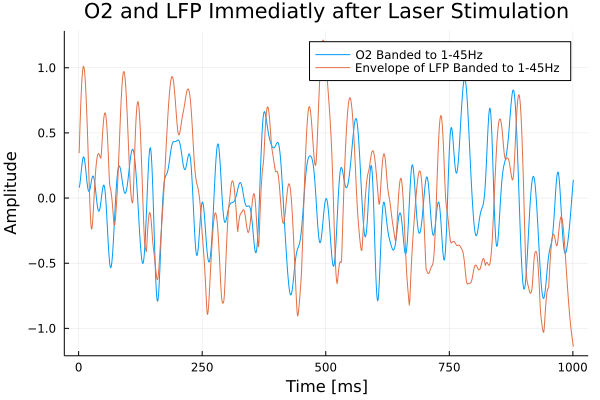

In [6]:
laser_flag = 1

o2_start = findall(x->x==o2["laser"][laser_flag], o2["timestamps"])[1]
lfp_start = findall(x->x==lfp["laser"]["on"][laser_flag], lfp["timestamps"])[1]
increment = 1000

lfp_channels_mean = zeros(increment+1)
for i in 1:4
    lfp_channels_mean += standardize(ZScoreTransform, lfp_envelopes[i][lfp_start:lfp_start+increment])
end
lfp_channels_mean ./= 4

plot(banded_o2[o2_start:o2_start+increment], label="O2 Banded to 1-45Hz")
plot!(lfp_channels_mean, label="Envelope of LFP Banded to 1-45Hz")

title!("O2 and LFP Immediatly after Laser Stimulation")
xlabel!("Time [ms]")
ylabel!("Amplitude")

In [7]:
for i in 1:4
    core = cor(banded_o2[o2_start:o2_start+increment], lfp_envelopes[i][lfp_start:lfp_start+increment])
    println("Channel $(i) correlation is: $(core)")
end
println(cor(banded_o2[o2_start:o2_start+increment], lfp_channels_mean))

Channel 1 correlation is: 0.08009996
Channel 2 correlation is: 0.31863838
Channel 3 correlation is: 0.059795544
Channel 4 correlation is: 0.07120583
0.2685125397245231


This first laser event shows a very promising correlation between the two datasets. Now lets plot the correlation value for each laser event.

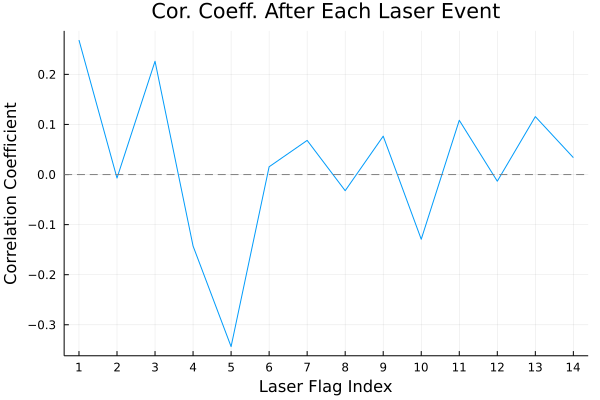

In [8]:
increment = 1000
cors = []

for flag in 1:length(o2["laser"])
    o2_start = findall(x->x==o2["laser"][flag], o2["timestamps"])[1]
    lfp_start = findall(x->x==lfp["laser"]["on"][flag], lfp["timestamps"])[1]

    lfp_channels_mean = zeros(increment+1)

    for i in 1:4
        lfp_channels_mean += standardize(ZScoreTransform, lfp_envelopes[i][lfp_start:lfp_start+increment])
    end
    lfp_channels_mean ./= 4

    push!(cors, cor(banded_o2[o2_start:o2_start+increment], lfp_channels_mean))
end

plot(cors, legend=false)
title!("Cor. Coeff. After Each Laser Event")
xlabel!("Laser Flag Index")
hline!([0], linestyle=:dash, colour=:grey)
xticks!((1:length(o2["laser"])))
ylabel!("Correlation Coefficient")


### All Events Averaged

This section will average the data immediately after each event and plot the result.

In [9]:
o2_starts = findall(x->x in o2["laser"], o2["timestamps"])[1:13]
lfp_starts = findall(x->x in lfp["laser"]["on"], lfp["timestamps"])[1:13]
increment = 1000

o2_subset_mean = zeros(increment+1)
lfp_subset_mean = zeros(increment+1)

for i in o2_starts
    o2_subset_mean += standardize(ZScoreTransform, banded_o2[i:i+increment])
end

for i in 1:4
    for j in lfp_starts
        lfp_subset_mean += standardize(ZScoreTransform, lfp_envelopes[i][j:j+increment])
    end
end

o2_subset_mean ./= length(o2_starts)
lfp_subset_mean ./= length(lfp_starts)
lfp_subset_mean ./= 4

1001-element Vector{Float64}:
  0.2900747209070967
  0.27503942623018074
  0.2590754010284749
  0.24145430125869238
  0.22159582981839776
  0.20034169126302004
  0.18042923603206873
  0.16143795697448346
  0.14146963958270276
  0.11839562081373654
  ⋮
 -0.09947520014471732
 -0.11639578747921266
 -0.13456286226685804
 -0.15355448940625557
 -0.1723614206107763
 -0.19027953907005632
 -0.208228014015521
 -0.2273590022053283
 -0.2455960338971076

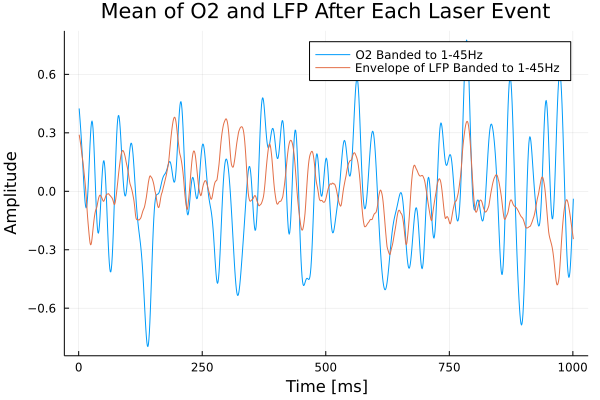

In [10]:
plot(o2_subset_mean, label="O2 Banded to 1-45Hz")
plot!(lfp_subset_mean, label="Envelope of LFP Banded to 1-45Hz")

title!("Mean of O2 and LFP After Each Laser Event")
xlabel!("Time [ms]")
ylabel!("Amplitude")

In [11]:
cor(o2_subset_mean, lfp_subset_mean)

0.11729346634488134

There is still some correlation after the laser events have been averaged. However, it is far weaker than the first data point.

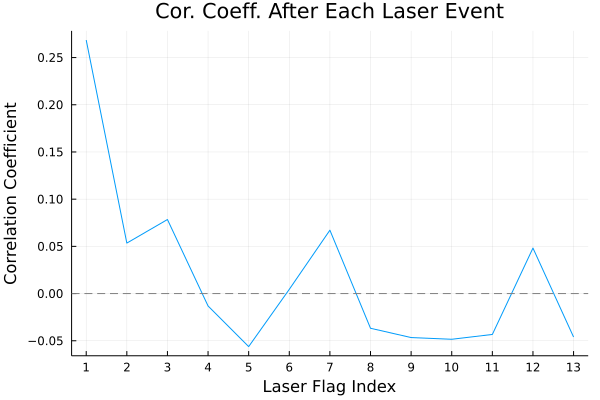

In [12]:
laser_flag = 1

o2_start = findall(x->x==o2["laser"][laser_flag], o2["timestamps"])[1]
lfp_starts = findall(x->x in lfp["laser"]["on"], lfp["timestamps"])[1:13]
increments = lfp_starts .- lfp_starts[1]
increment = 1000
cors = []

for flag in 1:13
    lfp_channels_mean = zeros(increment+1)

    for i in 1:4
        lfp_channels_mean += standardize(ZScoreTransform, lfp_envelopes[i][lfp_starts[flag]:lfp_starts[flag]+increment])
    end
    lfp_channels_mean ./= 4

    push!(cors, cor(banded_o2[o2_start+increments[flag]:o2_start+increments[flag]+increment], lfp_channels_mean))
end

plot(cors, legend=false)
title!("Cor. Coeff. After Each Laser Event")
xlabel!("Laser Flag Index")
hline!([0], linestyle=:dash, colour=:grey)
xticks!((1:length(o2["laser"])))
ylabel!("Correlation Coefficient")

## Modelling the First Laser Flag

As there is a clear correlation between the O2 and LFP data at the first laser flag, it will be possible to make a model. The aim of this section if to create an AR model for the purpose of practising modelling and finding a basic relationship.

$$y_i \sim Normal(\mu_i, \sigma_i)$$

$$\mu_i = \sum_{j=1}^{10}\beta_jx_{i-j}$$

$$\beta_j \sim Normal(0, \tau_\beta)$$

$$\tau_\beta \sim Gamma(2, 2)$$

$$\sigma_i \sim Gamma(2, 2)$$

In [13]:
laser_flag = 1
o2_start = findall(x->x==o2["laser"][laser_flag], o2["timestamps"])[1]
lfp_start = findall(x->x==lfp["laser"]["on"][laser_flag], lfp["timestamps"])[1]
increment = 1000

lfp_channels_mean = zeros(increment+1)
for i in 1:4
    lfp_channels_mean += standardize(ZScoreTransform, lfp_envelopes[i][lfp_start:lfp_start+increment])
end
lfp_channels_mean ./= 4

o2_subset = banded_o2[o2_start:o2_start+increment]
lfp_subset = lfp_channels_mean

1001-element Vector{Float64}:
  0.34467921778559685
  0.4627676219679415
  0.5786741599440575
  0.6866886243224144
  0.7828096300363541
  0.864195205271244
  0.928834930062294
  0.9753584153950214
  1.002938716672361
  1.0112449899315834
  ⋮
 -0.8770546540617943
 -0.9199302047491074
 -0.9591391012072563
 -0.9948326498270035
 -1.027595892548561
 -1.0582029521465302
 -1.087253674864769
 -1.114822268486023
 -1.140042468905449

In [76]:
lfp_subset

1001-element Vector{Float64}:
  0.34467921778559685
  0.4627676219679415
  0.5786741599440575
  0.6866886243224144
  0.7828096300363541
  0.864195205271244
  0.928834930062294
  0.9753584153950214
  1.002938716672361
  1.0112449899315834
  ⋮
 -0.8770546540617943
 -0.9199302047491074
 -0.9591391012072563
 -0.9948326498270035
 -1.027595892548561
 -1.0582029521465302
 -1.087253674864769
 -1.114822268486023
 -1.140042468905449

In [92]:
@model function AR(y, x)
    # Priors
    tau_beta ~ Gamma(2, 2)
    beta ~ filldist(Normal(0, 1), 10)
    sigma ~ Gamma(2, 2)

    for i in 10:length(y)
        mu = sum(x[i-9:i] .* beta .* tau_beta)
        y[i] ~ Normal(mu, sigma)
    end
end

DynamicPPL.ModelGen{var"###generator#954", (:y, :x), (), Tuple{}}(var"##generator#954", NamedTuple())

In [96]:
model = AR(o2_subset, lfp_subset)
chain = sample(model, NUTS(0.65), 1000)

┌ Info: Found initial step size
│   ϵ = 0.00625
└ @ Turing.Inference /home/alex/.julia/packages/Turing/GMBTf/src/inference/hmc.jl:629
Sampling   0%|                                          |  ETA: N/A
Sampling   0%|                                          |  ETA: 0:00:28
Sampling   0%|▏                                         |  ETA: 0:00:17
Sampling   0%|▏                                         |  ETA: 0:00:14
Sampling   0%|▏                                         |  ETA: 0:00:12
Sampling   0%|▎                                         |  ETA: 0:00:12
Sampling   1%|▎                                         |  ETA: 0:00:11
Sampling   1%|▎                                         |  ETA: 0:00:11
Sampling   1%|▍                                         |  ETA: 0:00:12
Sampling   1%|▍                                         |  ETA: 0:00:12
Sampling   1%|▍                                         |  ETA: 0:00:12
Sampling   1%|▌                                         |  ETA: 0:00:18
Sampli


Sampling  12%|████▉                                     |  ETA: 0:06:35
Sampling  12%|████▉                                     |  ETA: 0:06:42
Sampling  12%|█████                                     |  ETA: 0:06:39
Sampling  12%|█████                                     |  ETA: 0:06:45
Sampling  12%|█████                                     |  ETA: 0:06:45
Sampling  12%|█████▏                                    |  ETA: 0:06:43
Sampling  12%|█████▏                                    |  ETA: 0:06:40
Sampling  12%|█████▏                                    |  ETA: 0:06:46
Sampling  12%|█████▎                                    |  ETA: 0:06:43
Sampling  12%|█████▎                                    |  ETA: 0:06:39
Sampling  13%|█████▎                                    |  ETA: 0:06:45
Sampling  13%|█████▍                                    |  ETA: 0:06:44
Sampling  13%|█████▍                                    |  ETA: 0:06:49
Sampling  13%|█████▍                                    |  ETA:


Sampling  22%|█████████▍                                |  ETA: 0:06:12
Sampling  22%|█████████▍                                |  ETA: 0:06:10
Sampling  22%|█████████▍                                |  ETA: 0:06:08
Sampling  22%|█████████▌                                |  ETA: 0:06:07
Sampling  23%|█████████▌                                |  ETA: 0:06:05
Sampling  23%|█████████▌                                |  ETA: 0:06:03
Sampling  23%|█████████▋                                |  ETA: 0:06:02
Sampling  23%|█████████▋                                |  ETA: 0:06:00
Sampling  23%|█████████▋                                |  ETA: 0:05:59
Sampling  23%|█████████▊                                |  ETA: 0:05:58
Sampling  23%|█████████▊                                |  ETA: 0:05:56
Sampling  23%|█████████▊                                |  ETA: 0:05:56
Sampling  23%|█████████▉                                |  ETA: 0:05:55
Sampling  24%|█████████▉                                |  ETA:


Sampling  32%|█████████████▌                            |  ETA: 0:05:15
Sampling  32%|█████████████▌                            |  ETA: 0:05:14
Sampling  32%|█████████████▌                            |  ETA: 0:05:13
Sampling  32%|█████████████▋                            |  ETA: 0:05:13
Sampling  32%|█████████████▋                            |  ETA: 0:05:12
Sampling  32%|█████████████▋                            |  ETA: 0:05:12
Sampling  33%|█████████████▊                            |  ETA: 0:05:11
Sampling  33%|█████████████▊                            |  ETA: 0:05:10
Sampling  33%|█████████████▊                            |  ETA: 0:05:09
Sampling  33%|█████████████▉                            |  ETA: 0:05:09
Sampling  33%|█████████████▉                            |  ETA: 0:05:08
Sampling  33%|█████████████▉                            |  ETA: 0:05:07
Sampling  33%|██████████████                            |  ETA: 0:05:05
Sampling  33%|██████████████                            |  ETA:


Sampling  41%|█████████████████▎                        |  ETA: 0:04:19
Sampling  41%|█████████████████▎                        |  ETA: 0:04:20
Sampling  41%|█████████████████▍                        |  ETA: 0:04:19
Sampling  41%|█████████████████▍                        |  ETA: 0:04:18
Sampling  42%|█████████████████▍                        |  ETA: 0:04:18
Sampling  42%|█████████████████▌                        |  ETA: 0:04:18
Sampling  42%|█████████████████▌                        |  ETA: 0:04:17
Sampling  42%|█████████████████▌                        |  ETA: 0:04:16
Sampling  42%|█████████████████▋                        |  ETA: 0:04:16
Sampling  42%|█████████████████▋                        |  ETA: 0:04:15
Sampling  42%|█████████████████▋                        |  ETA: 0:04:14
Sampling  42%|█████████████████▊                        |  ETA: 0:04:13
Sampling  42%|█████████████████▊                        |  ETA: 0:04:13
Sampling  42%|█████████████████▊                        |  ETA:


Sampling  50%|████████████████████▉                     |  ETA: 0:03:47
Sampling  50%|████████████████████▉                     |  ETA: 0:03:47
Sampling  50%|████████████████████▉                     |  ETA: 0:03:47
Sampling  50%|█████████████████████                     |  ETA: 0:03:46
Sampling  50%|█████████████████████                     |  ETA: 0:03:45
Sampling  50%|█████████████████████                     |  ETA: 0:03:45
Sampling  50%|█████████████████████▏                    |  ETA: 0:03:45
Sampling  50%|█████████████████████▏                    |  ETA: 0:03:44
Sampling  50%|█████████████████████▏                    |  ETA: 0:03:44
Sampling  50%|█████████████████████▎                    |  ETA: 0:03:43
Sampling  51%|█████████████████████▎                    |  ETA: 0:03:43
Sampling  51%|█████████████████████▎                    |  ETA: 0:03:42
Sampling  51%|█████████████████████▍                    |  ETA: 0:03:42
Sampling  51%|█████████████████████▍                    |  ETA:


Sampling  58%|████████████████████████▎                 |  ETA: 0:03:12
Sampling  58%|████████████████████████▎                 |  ETA: 0:03:12
Sampling  58%|████████████████████████▍                 |  ETA: 0:03:11
Sampling  58%|████████████████████████▍                 |  ETA: 0:03:11
Sampling  58%|████████████████████████▍                 |  ETA: 0:03:10
Sampling  58%|████████████████████████▌                 |  ETA: 0:03:10
Sampling  58%|████████████████████████▌                 |  ETA: 0:03:09
Sampling  58%|████████████████████████▌                 |  ETA: 0:03:08
Sampling  58%|████████████████████████▋                 |  ETA: 0:03:08
Sampling  59%|████████████████████████▋                 |  ETA: 0:03:08
Sampling  59%|████████████████████████▋                 |  ETA: 0:03:07
Sampling  59%|████████████████████████▊                 |  ETA: 0:03:07
Sampling  59%|████████████████████████▊                 |  ETA: 0:03:06
Sampling  59%|████████████████████████▊                 |  ETA:


Sampling  65%|███████████████████████████▌              |  ETA: 0:02:37
Sampling  66%|███████████████████████████▌              |  ETA: 0:02:37
Sampling  66%|███████████████████████████▌              |  ETA: 0:02:36
Sampling  66%|███████████████████████████▋              |  ETA: 0:02:36
Sampling  66%|███████████████████████████▋              |  ETA: 0:02:36
Sampling  66%|███████████████████████████▋              |  ETA: 0:02:35
Sampling  66%|███████████████████████████▊              |  ETA: 0:02:35
Sampling  66%|███████████████████████████▊              |  ETA: 0:02:34
Sampling  66%|███████████████████████████▊              |  ETA: 0:02:34
Sampling  66%|███████████████████████████▉              |  ETA: 0:02:33
Sampling  66%|███████████████████████████▉              |  ETA: 0:02:33
Sampling  66%|███████████████████████████▉              |  ETA: 0:02:32
Sampling  67%|████████████████████████████              |  ETA: 0:02:32
Sampling  67%|████████████████████████████              |  ETA:


Sampling  73%|██████████████████████████████▌           |  ETA: 0:02:03
Sampling  73%|██████████████████████████████▋           |  ETA: 0:02:03
Sampling  73%|██████████████████████████████▋           |  ETA: 0:02:03
Sampling  73%|██████████████████████████████▋           |  ETA: 0:02:02
Sampling  73%|██████████████████████████████▊           |  ETA: 0:02:02
Sampling  73%|██████████████████████████████▊           |  ETA: 0:02:01
Sampling  73%|██████████████████████████████▊           |  ETA: 0:02:01
Sampling  73%|██████████████████████████████▉           |  ETA: 0:02:00
Sampling  74%|██████████████████████████████▉           |  ETA: 0:02:00
Sampling  74%|██████████████████████████████▉           |  ETA: 0:01:59
Sampling  74%|███████████████████████████████           |  ETA: 0:01:59
Sampling  74%|███████████████████████████████           |  ETA: 0:01:58
Sampling  74%|███████████████████████████████           |  ETA: 0:01:58
Sampling  74%|███████████████████████████████▏          |  ETA:


Sampling  80%|█████████████████████████████████▌        |  ETA: 0:01:32
Sampling  80%|█████████████████████████████████▌        |  ETA: 0:01:32
Sampling  80%|█████████████████████████████████▌        |  ETA: 0:01:31
Sampling  80%|█████████████████████████████████▋        |  ETA: 0:01:31
Sampling  80%|█████████████████████████████████▋        |  ETA: 0:01:30
Sampling  80%|█████████████████████████████████▋        |  ETA: 0:01:30
Sampling  80%|█████████████████████████████████▊        |  ETA: 0:01:30
Sampling  80%|█████████████████████████████████▊        |  ETA: 0:01:29
Sampling  80%|█████████████████████████████████▊        |  ETA: 0:01:29
Sampling  81%|█████████████████████████████████▉        |  ETA: 0:01:28
Sampling  81%|█████████████████████████████████▉        |  ETA: 0:01:28
Sampling  81%|█████████████████████████████████▉        |  ETA: 0:01:27
Sampling  81%|██████████████████████████████████        |  ETA: 0:01:27
Sampling  81%|██████████████████████████████████        |  ETA:


Sampling  86%|████████████████████████████████████▍     |  ETA: 0:01:01
Sampling  87%|████████████████████████████████████▍     |  ETA: 0:01:01
Sampling  87%|████████████████████████████████████▍     |  ETA: 0:01:00
Sampling  87%|████████████████████████████████████▌     |  ETA: 0:01:00
Sampling  87%|████████████████████████████████████▌     |  ETA: 0:01:00
Sampling  87%|████████████████████████████████████▌     |  ETA: 0:00:59
Sampling  87%|████████████████████████████████████▋     |  ETA: 0:00:59
Sampling  87%|████████████████████████████████████▋     |  ETA: 0:00:58
Sampling  87%|████████████████████████████████████▋     |  ETA: 0:00:58
Sampling  87%|████████████████████████████████████▊     |  ETA: 0:00:57
Sampling  88%|████████████████████████████████████▊     |  ETA: 0:00:57
Sampling  88%|████████████████████████████████████▊     |  ETA: 0:00:56
Sampling  88%|████████████████████████████████████▉     |  ETA: 0:00:56
Sampling  88%|████████████████████████████████████▉     |  ETA:


Sampling  93%|███████████████████████████████████████   |  ETA: 0:00:32
Sampling  93%|███████████████████████████████████████▏  |  ETA: 0:00:31
Sampling  93%|███████████████████████████████████████▏  |  ETA: 0:00:31
Sampling  93%|███████████████████████████████████████▏  |  ETA: 0:00:31
Sampling  93%|███████████████████████████████████████▎  |  ETA: 0:00:30
Sampling  94%|███████████████████████████████████████▎  |  ETA: 0:00:30
Sampling  94%|███████████████████████████████████████▎  |  ETA: 0:00:29
Sampling  94%|███████████████████████████████████████▍  |  ETA: 0:00:29
Sampling  94%|███████████████████████████████████████▍  |  ETA: 0:00:28
Sampling  94%|███████████████████████████████████████▌  |  ETA: 0:00:28
Sampling  94%|███████████████████████████████████████▌  |  ETA: 0:00:27
Sampling  94%|███████████████████████████████████████▌  |  ETA: 0:00:27
Sampling  94%|███████████████████████████████████████▋  |  ETA: 0:00:26
Sampling  94%|███████████████████████████████████████▋  |  ETA:


Sampling  99%|█████████████████████████████████████████▊|  ETA: 0:00:03
Sampling  99%|█████████████████████████████████████████▊|  ETA: 0:00:03
Sampling 100%|█████████████████████████████████████████▊|  ETA: 0:00:02
Sampling 100%|█████████████████████████████████████████▉|  ETA: 0:00:02
Sampling 100%|█████████████████████████████████████████▉|  ETA: 0:00:01
Sampling 100%|█████████████████████████████████████████▉|  ETA: 0:00:01
Sampling 100%|██████████████████████████████████████████|  ETA: 0:00:00
Sampling 100%|██████████████████████████████████████████| Time: 0:07:38
Sampling 100%|██████████████████████████████████████████| Time: 0:07:38


Object of type Chains, with data of type 500×24×1 Array{Float64, 3}

Iterations        = 1:500
Thinning interval = 1
Chains            = 1
Samples per chain = 500
internals         = acceptance_rate, hamiltonian_energy, hamiltonian_energy_error, is_accept, log_density, lp, max_hamiltonian_energy_error, n_steps, nom_step_size, numerical_error, step_size, tree_depth
parameters        = beta[1], beta[2], beta[3], beta[4], beta[5], beta[6], beta[7], beta[8], beta[9], beta[10], sigma, tau_beta

2-element Vector{ChainDataFrame}

Summary Statistics
  parameters     mean     std  naive_se    mcse       ess   r_hat
  ──────────  ───────  ──────  ────────  ──────  ────────  ──────
     beta[1]   0.4277  0.5840    0.0261  0.0344  265.5504  1.0071
     beta[2]   0.1108  0.7984    0.0357  0.0183  219.3499  1.0023
     beta[3]  -0.2332  0.8029    0.0359  0.0516  290.7595  0.9981
     beta[4]  -0.2242  0.8541    0.0382  0.0243  339.0426  1.0001
     beta[5]  -0.0584  0.8813    0.0394  0.0402  272.432

In [149]:
plot(chain)

In [124]:
length(chain)
parms = chain.name_map.parameters

using Random, Distributions
Random.seed!(123) # Setting the seed

function posteriorSample(chain)
    parms = chain.name_map.parameters
    idx = rand(1:length(chain))
    return map(x->chain[x].value[idx] , parms)
end

postSample = [posteriorSample(chain) for i in 1:1000]

predictions = []
for i in 10:length(lfp_subset)
    pred_i = []
    for sample in postSample
        mu = sum(lfp_subset[i-9:i] .* sample[1:10] .* sample[12])
        post = rand(Normal(mu, sample[11]), 1)
        push!(pred_i, post[1])
    end
    push!(predictions, pred_i)
end

992-element Vector{Any}:
 Any[0.20515700916766877, 0.1360300548931872, 0.4206739748383689, 0.6288697329072164, 0.3812784984827274, 0.6825352638275584, 0.10639186357221277, -0.4762130750426822, 0.06161328852862863, 0.25552478786132626  …  -0.7113245094216666, 0.4917429040664787, 0.18714724950038333, 0.264174288742287, 0.5162364235018828, 0.7677931393131474, 0.09196476787731817, 0.6957907744433274, 0.5042022972079971, 0.5644414179012593]
 Any[0.6206700503527904, 0.008931534431671842, -0.2142060431190569, 0.20701981282216672, -0.339489899184024, 0.4646088949874274, -0.18499312058392509, 0.022289788596420307, -0.10237830360410732, -0.4745133746503897  …  0.052465364697735384, 0.2504468006415321, -0.017086868754327245, 0.688735005619927, 0.18127626165843583, 0.4534579754192519, 0.06950827015022593, -0.1788309925750901, 0.5156633945613802, 0.21423087991390763]
 Any[0.4970197685202256, -0.009786424340792743, 0.853889528267527, 0.10792746901024597, -0.5851055363241822, -0.2094370893860497, 0.3

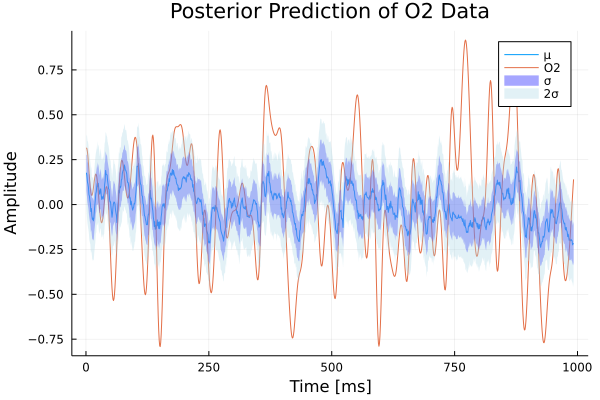

In [151]:
means = [mean(predictions[i]) for i in 1:length(predictions)]
vars = [var(predictions[i]) for i in 1:length(predictions)]

plot(means, label="μ")
plot!(o2_subset[10:end], label="O2")
plot!(means.-vars, fillrange=means.+vars, fillalpha = 0.35, linealpha=0, c="Blue", label="σ")
plot!(means.-(2*vars), fillrange=means.+(2*vars), fillalpha = 0.35, linealpha=0, c="Light Blue", label="2σ")

title!("Posterior Prediction of O2 Data")
xlabel!("Time [ms]")
ylabel!("Amplitude")

In [148]:
cor(means, o2_subset[10:end])

0.3001232045410527

### Addressing Multicollinearity

The issue with the model above is that there will be an auto correlation between $x_{i-10}$ to $x_i$ this will cause multicollinearity between all values of $\beta$ making their actual values arbitrary. This can be fixed by modifying the model.

$$y_i \sim Normal(\mu_i, \sigma_i)$$

$$\mu_i = \beta\sum_{j=1}^{10}x_{i-j}$$

$$\beta \sim Normal(0, \tau_\beta)$$

$$\tau_\beta \sim Gamma(2, 2)$$

$$\sigma_i \sim Gamma(2, 2)$$

In [167]:
@model function AR_no_multi_colin(y, x)
    # Priors
    tau_beta ~ Gamma(2, 2)
    beta ~ Normal(0, 1)
    sigma ~ Gamma(2, 2)

    for i in 10:length(y)
        mu = x[i] * beta * tau_beta
        y[i] ~ Normal(mu, sigma)
    end
end

DynamicPPL.ModelGen{var"###generator#1168", (:y, :x), (), Tuple{}}(var"##generator#1168", NamedTuple())

In [168]:
model = AR_no_multi_colin(o2_subset, lfp_subset)
chain = sample(model, NUTS(0.65), 1000)

┌ Info: Found initial step size
│   ϵ = 0.0125
└ @ Turing.Inference /home/alex/.julia/packages/Turing/GMBTf/src/inference/hmc.jl:629
Sampling   0%|                                          |  ETA: N/A
Sampling   0%|                                          |  ETA: 0:13:03
Sampling   0%|▏                                         |  ETA: 0:08:00
Sampling   0%|▏                                         |  ETA: 0:05:21
Sampling   0%|▏                                         |  ETA: 0:04:03
Sampling   0%|▎                                         |  ETA: 0:03:15
Sampling   1%|▎                                         |  ETA: 0:02:43
Sampling   1%|▎                                         |  ETA: 0:02:20
Sampling   1%|▍                                         |  ETA: 0:02:04
Sampling   1%|▍                                         |  ETA: 0:01:51
Sampling   1%|▍                                         |  ETA: 0:01:42
Sampling   1%|▌                                         |  ETA: 0:01:33
Samplin


Sampling  12%|████▉                                     |  ETA: 0:00:55
Sampling  12%|████▉                                     |  ETA: 0:00:55
Sampling  12%|█████                                     |  ETA: 0:00:55
Sampling  12%|█████                                     |  ETA: 0:00:55
Sampling  12%|█████                                     |  ETA: 0:00:55
Sampling  12%|█████▏                                    |  ETA: 0:00:54
Sampling  12%|█████▏                                    |  ETA: 0:00:55
Sampling  12%|█████▏                                    |  ETA: 0:00:54
Sampling  12%|█████▎                                    |  ETA: 0:00:54
Sampling  12%|█████▎                                    |  ETA: 0:00:54
Sampling  13%|█████▎                                    |  ETA: 0:00:54
Sampling  13%|█████▍                                    |  ETA: 0:00:53
Sampling  13%|█████▍                                    |  ETA: 0:00:53
Sampling  13%|█████▍                                    |  ETA:


Sampling  22%|█████████▍                                |  ETA: 0:00:47
Sampling  22%|█████████▍                                |  ETA: 0:00:47
Sampling  22%|█████████▍                                |  ETA: 0:00:46
Sampling  22%|█████████▌                                |  ETA: 0:00:46
Sampling  23%|█████████▌                                |  ETA: 0:00:46
Sampling  23%|█████████▌                                |  ETA: 0:00:46
Sampling  23%|█████████▋                                |  ETA: 0:00:46
Sampling  23%|█████████▋                                |  ETA: 0:00:46
Sampling  23%|█████████▋                                |  ETA: 0:00:46
Sampling  23%|█████████▊                                |  ETA: 0:00:45
Sampling  23%|█████████▊                                |  ETA: 0:00:45
Sampling  23%|█████████▊                                |  ETA: 0:00:45
Sampling  23%|█████████▉                                |  ETA: 0:00:45
Sampling  24%|█████████▉                                |  ETA:


Sampling  32%|█████████████▌                            |  ETA: 0:00:39
Sampling  32%|█████████████▌                            |  ETA: 0:00:39
Sampling  32%|█████████████▌                            |  ETA: 0:00:39
Sampling  32%|█████████████▋                            |  ETA: 0:00:38
Sampling  32%|█████████████▋                            |  ETA: 0:00:38
Sampling  32%|█████████████▋                            |  ETA: 0:00:38
Sampling  33%|█████████████▊                            |  ETA: 0:00:38
Sampling  33%|█████████████▊                            |  ETA: 0:00:38
Sampling  33%|█████████████▊                            |  ETA: 0:00:38
Sampling  33%|█████████████▉                            |  ETA: 0:00:38
Sampling  33%|█████████████▉                            |  ETA: 0:00:38
Sampling  33%|█████████████▉                            |  ETA: 0:00:38
Sampling  33%|██████████████                            |  ETA: 0:00:37
Sampling  33%|██████████████                            |  ETA:


Sampling  41%|█████████████████▎                        |  ETA: 0:00:33
Sampling  41%|█████████████████▎                        |  ETA: 0:00:32
Sampling  41%|█████████████████▍                        |  ETA: 0:00:32
Sampling  41%|█████████████████▍                        |  ETA: 0:00:32
Sampling  42%|█████████████████▍                        |  ETA: 0:00:32
Sampling  42%|█████████████████▌                        |  ETA: 0:00:33
Sampling  42%|█████████████████▌                        |  ETA: 0:00:32
Sampling  42%|█████████████████▌                        |  ETA: 0:00:32
Sampling  42%|█████████████████▋                        |  ETA: 0:00:32
Sampling  42%|█████████████████▋                        |  ETA: 0:00:32
Sampling  42%|█████████████████▋                        |  ETA: 0:00:32
Sampling  42%|█████████████████▊                        |  ETA: 0:00:32
Sampling  42%|█████████████████▊                        |  ETA: 0:00:32
Sampling  42%|█████████████████▊                        |  ETA:


Sampling  50%|████████████████████▉                     |  ETA: 0:00:27
Sampling  50%|████████████████████▉                     |  ETA: 0:00:27
Sampling  50%|████████████████████▉                     |  ETA: 0:00:27
Sampling  50%|█████████████████████                     |  ETA: 0:00:26
Sampling  50%|█████████████████████                     |  ETA: 0:00:26
Sampling  50%|█████████████████████                     |  ETA: 0:00:26
Sampling  50%|█████████████████████▏                    |  ETA: 0:00:26
Sampling  50%|█████████████████████▏                    |  ETA: 0:00:26
Sampling  50%|█████████████████████▏                    |  ETA: 0:00:26
Sampling  50%|█████████████████████▎                    |  ETA: 0:00:26
Sampling  51%|█████████████████████▎                    |  ETA: 0:00:26
Sampling  51%|█████████████████████▎                    |  ETA: 0:00:26
Sampling  51%|█████████████████████▍                    |  ETA: 0:00:26
Sampling  51%|█████████████████████▍                    |  ETA:


Sampling  58%|████████████████████████▎                 |  ETA: 0:00:21
Sampling  58%|████████████████████████▎                 |  ETA: 0:00:21
Sampling  58%|████████████████████████▍                 |  ETA: 0:00:21
Sampling  58%|████████████████████████▍                 |  ETA: 0:00:21
Sampling  58%|████████████████████████▍                 |  ETA: 0:00:21
Sampling  58%|████████████████████████▌                 |  ETA: 0:00:21
Sampling  58%|████████████████████████▌                 |  ETA: 0:00:21
Sampling  58%|████████████████████████▌                 |  ETA: 0:00:21
Sampling  58%|████████████████████████▋                 |  ETA: 0:00:21
Sampling  59%|████████████████████████▋                 |  ETA: 0:00:21
Sampling  59%|████████████████████████▋                 |  ETA: 0:00:21
Sampling  59%|████████████████████████▊                 |  ETA: 0:00:21
Sampling  59%|████████████████████████▊                 |  ETA: 0:00:20
Sampling  59%|████████████████████████▊                 |  ETA:


Sampling  65%|███████████████████████████▌              |  ETA: 0:00:16
Sampling  66%|███████████████████████████▌              |  ETA: 0:00:16
Sampling  66%|███████████████████████████▌              |  ETA: 0:00:16
Sampling  66%|███████████████████████████▋              |  ETA: 0:00:16
Sampling  66%|███████████████████████████▋              |  ETA: 0:00:16
Sampling  66%|███████████████████████████▋              |  ETA: 0:00:16
Sampling  66%|███████████████████████████▊              |  ETA: 0:00:16
Sampling  66%|███████████████████████████▊              |  ETA: 0:00:16
Sampling  66%|███████████████████████████▊              |  ETA: 0:00:16
Sampling  66%|███████████████████████████▉              |  ETA: 0:00:16
Sampling  66%|███████████████████████████▉              |  ETA: 0:00:16
Sampling  66%|███████████████████████████▉              |  ETA: 0:00:16
Sampling  67%|████████████████████████████              |  ETA: 0:00:16
Sampling  67%|████████████████████████████              |  ETA:


Sampling  73%|██████████████████████████████▌           |  ETA: 0:00:13
Sampling  73%|██████████████████████████████▋           |  ETA: 0:00:13
Sampling  73%|██████████████████████████████▋           |  ETA: 0:00:13
Sampling  73%|██████████████████████████████▋           |  ETA: 0:00:12
Sampling  73%|██████████████████████████████▊           |  ETA: 0:00:12
Sampling  73%|██████████████████████████████▊           |  ETA: 0:00:12
Sampling  73%|██████████████████████████████▊           |  ETA: 0:00:12
Sampling  73%|██████████████████████████████▉           |  ETA: 0:00:12
Sampling  74%|██████████████████████████████▉           |  ETA: 0:00:12
Sampling  74%|██████████████████████████████▉           |  ETA: 0:00:12
Sampling  74%|███████████████████████████████           |  ETA: 0:00:12
Sampling  74%|███████████████████████████████           |  ETA: 0:00:12
Sampling  74%|███████████████████████████████           |  ETA: 0:00:12
Sampling  74%|███████████████████████████████▏          |  ETA:


Sampling  80%|█████████████████████████████████▌        |  ETA: 0:00:09
Sampling  80%|█████████████████████████████████▌        |  ETA: 0:00:09
Sampling  80%|█████████████████████████████████▌        |  ETA: 0:00:09
Sampling  80%|█████████████████████████████████▋        |  ETA: 0:00:09
Sampling  80%|█████████████████████████████████▋        |  ETA: 0:00:09
Sampling  80%|█████████████████████████████████▋        |  ETA: 0:00:09
Sampling  80%|█████████████████████████████████▊        |  ETA: 0:00:09
Sampling  80%|█████████████████████████████████▊        |  ETA: 0:00:09
Sampling  80%|█████████████████████████████████▊        |  ETA: 0:00:09
Sampling  81%|█████████████████████████████████▉        |  ETA: 0:00:09
Sampling  81%|█████████████████████████████████▉        |  ETA: 0:00:09
Sampling  81%|█████████████████████████████████▉        |  ETA: 0:00:09
Sampling  81%|██████████████████████████████████        |  ETA: 0:00:09
Sampling  81%|██████████████████████████████████        |  ETA:


Sampling  86%|████████████████████████████████████▍     |  ETA: 0:00:06
Sampling  87%|████████████████████████████████████▍     |  ETA: 0:00:06
Sampling  87%|████████████████████████████████████▍     |  ETA: 0:00:06
Sampling  87%|████████████████████████████████████▌     |  ETA: 0:00:06
Sampling  87%|████████████████████████████████████▌     |  ETA: 0:00:06
Sampling  87%|████████████████████████████████████▌     |  ETA: 0:00:06
Sampling  87%|████████████████████████████████████▋     |  ETA: 0:00:06
Sampling  87%|████████████████████████████████████▋     |  ETA: 0:00:06
Sampling  87%|████████████████████████████████████▋     |  ETA: 0:00:06
Sampling  87%|████████████████████████████████████▊     |  ETA: 0:00:06
Sampling  88%|████████████████████████████████████▊     |  ETA: 0:00:06
Sampling  88%|████████████████████████████████████▊     |  ETA: 0:00:06
Sampling  88%|████████████████████████████████████▉     |  ETA: 0:00:05
Sampling  88%|████████████████████████████████████▉     |  ETA:


Sampling  93%|███████████████████████████████████████   |  ETA: 0:00:03
Sampling  93%|███████████████████████████████████████▏  |  ETA: 0:00:03
Sampling  93%|███████████████████████████████████████▏  |  ETA: 0:00:03
Sampling  93%|███████████████████████████████████████▏  |  ETA: 0:00:03
Sampling  93%|███████████████████████████████████████▎  |  ETA: 0:00:03
Sampling  94%|███████████████████████████████████████▎  |  ETA: 0:00:03
Sampling  94%|███████████████████████████████████████▎  |  ETA: 0:00:03
Sampling  94%|███████████████████████████████████████▍  |  ETA: 0:00:03
Sampling  94%|███████████████████████████████████████▍  |  ETA: 0:00:03
Sampling  94%|███████████████████████████████████████▌  |  ETA: 0:00:03
Sampling  94%|███████████████████████████████████████▌  |  ETA: 0:00:03
Sampling  94%|███████████████████████████████████████▌  |  ETA: 0:00:02
Sampling  94%|███████████████████████████████████████▋  |  ETA: 0:00:02
Sampling  94%|███████████████████████████████████████▋  |  ETA:


Sampling  99%|█████████████████████████████████████████▊|  ETA: 0:00:00
Sampling  99%|█████████████████████████████████████████▊|  ETA: 0:00:00
Sampling 100%|█████████████████████████████████████████▊|  ETA: 0:00:00
Sampling 100%|█████████████████████████████████████████▉|  ETA: 0:00:00
Sampling 100%|█████████████████████████████████████████▉|  ETA: 0:00:00
Sampling 100%|█████████████████████████████████████████▉|  ETA: 0:00:00
Sampling 100%|██████████████████████████████████████████|  ETA: 0:00:00
Sampling 100%|██████████████████████████████████████████| Time: 0:00:42
Sampling 100%|██████████████████████████████████████████| Time: 0:00:42


Object of type Chains, with data of type 500×15×1 Array{Float64, 3}

Iterations        = 1:500
Thinning interval = 1
Chains            = 1
Samples per chain = 500
internals         = acceptance_rate, hamiltonian_energy, hamiltonian_energy_error, is_accept, log_density, lp, max_hamiltonian_energy_error, n_steps, nom_step_size, numerical_error, step_size, tree_depth
parameters        = beta, sigma, tau_beta

2-element Vector{ChainDataFrame}

Summary Statistics
  parameters    mean     std  naive_se    mcse      ess   r_hat
  ──────────  ──────  ──────  ────────  ──────  ───────  ──────
        beta  0.2806  0.2194    0.0098  0.0263  38.7434  1.0279
       sigma  0.3364  0.0074    0.0003  0.0010  47.3411  0.9985
    tau_beta  1.0533  0.6344    0.0284  0.1044  20.7556  1.0291

Quantiles
  parameters    2.5%   25.0%   50.0%   75.0%   97.5%
  ──────────  ──────  ──────  ──────  ──────  ──────
        beta  0.0808  0.1189  0.2016  0.3771  0.7993
       sigma  0.3230  0.3312  0.3356  0.3414  0

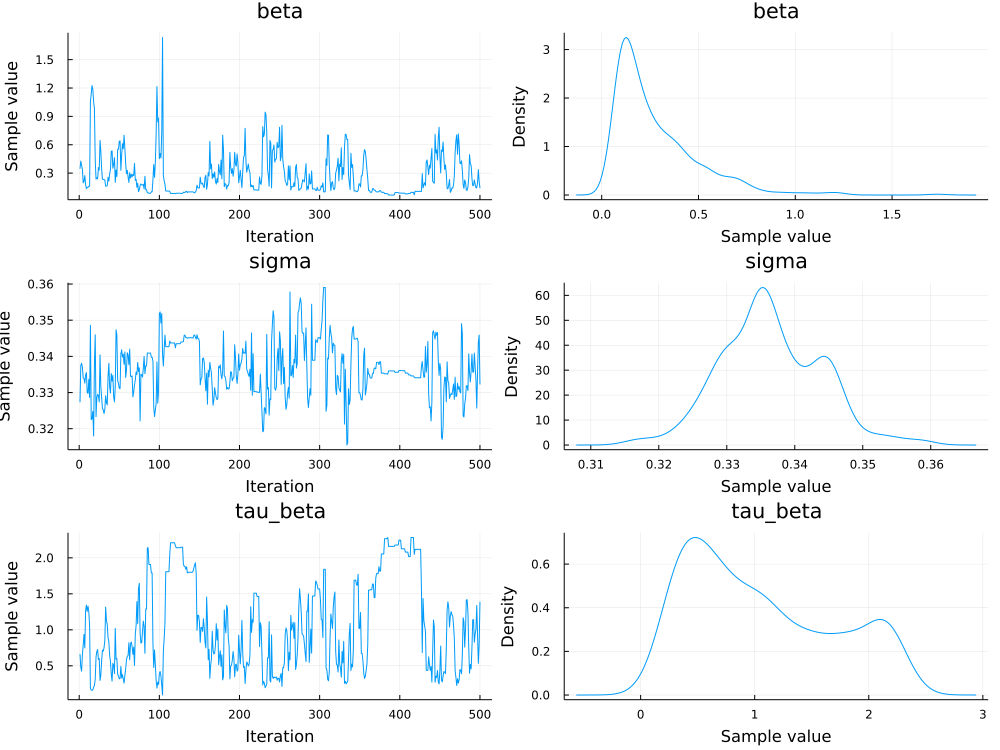

In [169]:
plot(chain)

In [172]:
length(chain)
parms = chain.name_map.parameters

using Random, Distributions
Random.seed!(123) # Setting the seed

function posteriorSample(chain)
    parms = chain.name_map.parameters
    idx = rand(1:length(chain))
    return map(x->chain[x].value[idx] , parms)
end

postSample = [posteriorSample(chain) for i in 1:1000]

predictions = []
for i in 10:length(lfp_subset)
    pred_i = []
    for sample in postSample
        mu = sum(lfp_subset[i-9:i]) * sample[1] * sample[3]
        post = rand(Normal(mu, sample[2]), 1)
        push!(pred_i, post[1])
    end
    push!(predictions, pred_i)
end

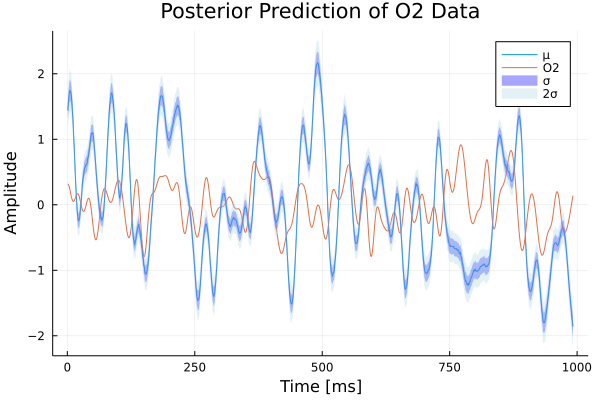

In [173]:
means = [mean(predictions[i]) for i in 1:length(predictions)]
vars = [var(predictions[i]) for i in 1:length(predictions)]

plot(means, label="μ")
plot!(o2_subset[10:end], label="O2")
plot!(means.-vars, fillrange=means.+vars, fillalpha = 0.35, linealpha=0, c="Blue", label="σ")
plot!(means.-(2*vars), fillrange=means.+(2*vars), fillalpha = 0.35, linealpha=0, c="Light Blue", label="2σ")

title!("Posterior Prediction of O2 Data")
xlabel!("Time [ms]")
ylabel!("Amplitude")